# A hierarchcial linear regression to fit CRISPR-Cas9 screen results

The CERES model was replicated using PyMC3 in []().
This notebook is intended to experiment with various hierarchical model architectures on a sub-sample of the real DepMap data.

## Set-up

In [1]:
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import pymc3_helpers as pmhelp
import seaborn as sns
import string_functions as stringr
from common_data_processing import get_indices, make_cat, zscale_cna_by_group
from pymc3_helpers import pymc3_sampling_procedure, samples_to_arviz
from theano import tensor as tt

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_minimal())

%config InlineBackend.figure_format = 'retina'

RANDOM_SEED = 824
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("pymc3_model_cache")

## Data preparation

In [2]:
data_path = Path("../modeling_data/depmap_modeling_dataframe_subsample.csv")
data = pd.read_csv(data_path)
data.head(n=7)

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,log2_gene_cn_p1,gene_cn,n_muts,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr
0,AAGAGGCCGGTCAAATTCAG,42-mg-ba-311cas9_repa_p6_batch3,-0.405499,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.845287,1.328646,0,False,NaN,NaN,NaN,NaN,False,1.263034
1,AATCAACCCACAGCTGCACA,42-mg-ba-311cas9_repa_p6_batch3,-0.133541,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.827398,1.287359,2,False,missense_mutation;missense_mutation,FALSE;FALSE,TRUE;TRUE,TRUE;TRUE,False,5.220330
2,AATTACTACTTGCTTCCTGT,42-mg-ba-311cas9_repa_p6_batch3,-0.491495,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.879280,1.409165,0,False,NaN,NaN,NaN,NaN,False,3.008989
3,ACCTGTATGACGAAACCGTG,42-mg-ba-311cas9_repa_p6_batch3,-0.015850,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
4,ACTCTGTTCCTTCATCTCCG,42-mg-ba-311cas9_repa_p6_batch3,-0.530277,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.990378,1.692253,0,False,NaN,NaN,NaN,NaN,False,5.822730
5,ACTGCTGCGGGAATTCCAAG,42-mg-ba-311cas9_repa_p6_batch3,0.778827,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.818549,1.267208,0,False,NaN,NaN,NaN,NaN,False,4.083213
6,AGACACTTATACTATGAAAG,42-mg-ba-311cas9_repa_p6_batch3,0.035950,3,True,ACH-000323,Primary,central_nervous_system,glioma,WT,...,0.872323,1.392463,0,False,NaN,NaN,NaN,NaN,False,3.701549


In [3]:
data.describe()

,lfc,pdna_batch,n_alignments,chromosome,chrom_pos,segment_mean,segment_cn,log2_gene_cn_p1,gene_cn,n_muts,rna_expr
count,60049.000000,60049.000000,60049.000000,60049.000000,6.004900e+04,5.984300e+04,5.984300e+04,6.004900e+04,6.004900e+04,60049.000000,60049.000000
mean,-0.110098,2.861063,1.029126,8.796117,8.199159e+07,1.052517e+00,3.673521e+12,1.012354e+00,1.894709e+00,0.097654,2.957374
std,0.562585,0.355663,0.168162,6.526117,6.014320e+07,8.296245e-01,3.177012e+14,2.294065e-01,4.336833e+00,0.354338,2.292989
min,-4.972325,2.000000,1.000000,1.000000,7.675103e+06,9.598765e-08,1.000000e+00,5.506197e-09,5.506197e-09,0.000000,0.000000
25%,-0.344279,3.000000,1.000000,3.000000,3.201892e+07,8.530658e-01,1.806335e+00,8.900191e-01,1.435176e+00,0.000000,0.790772
50%,-0.033168,3.000000,1.000000,8.000000,5.977335e+07,1.005954e+00,2.008272e+00,1.004289e+00,1.729965e+00,0.000000,2.895303
75%,0.218036,3.000000,1.000000,16.000000,1.375787e+08,1.154679e+00,2.226348e+00,1.107473e+00,2.026700e+00,0.000000,4.698218
max,5.598174,4.000000,2.000000,20.000000,2.230033e+08,5.460920e+01,2.747932e+16,5.797252e+00,3.283930e+02,8.000000,11.496005


In [4]:
for col in ("hugo_symbol", "depmap_id"):
    data = make_cat(data, col, ordered=True, sort_cats=True)

In [5]:
data.shape

(60049, 27)

In [6]:
data = zscale_cna_by_group(data, cn_max=10)

## EDA

In [7]:
data.columns

Index(['sgrna', 'replicate_id', 'lfc', 'pdna_batch', 'passes_qc', 'depmap_id',
       'primary_or_metastasis', 'lineage', 'lineage_subtype', 'kras_mutation',
       'genome_alignment', 'n_alignments', 'hugo_symbol', 'chromosome',
       'chrom_pos', 'segment_mean', 'segment_cn', 'log2_gene_cn_p1', 'gene_cn',
       'n_muts', 'any_deleterious', 'variant_classification', 'is_deleterious',
       'is_tcga_hotspot', 'is_cosmic_hotspot', 'mutated_at_guide_location',
       'rna_expr', 'gene_cn_z'],
      dtype='object')

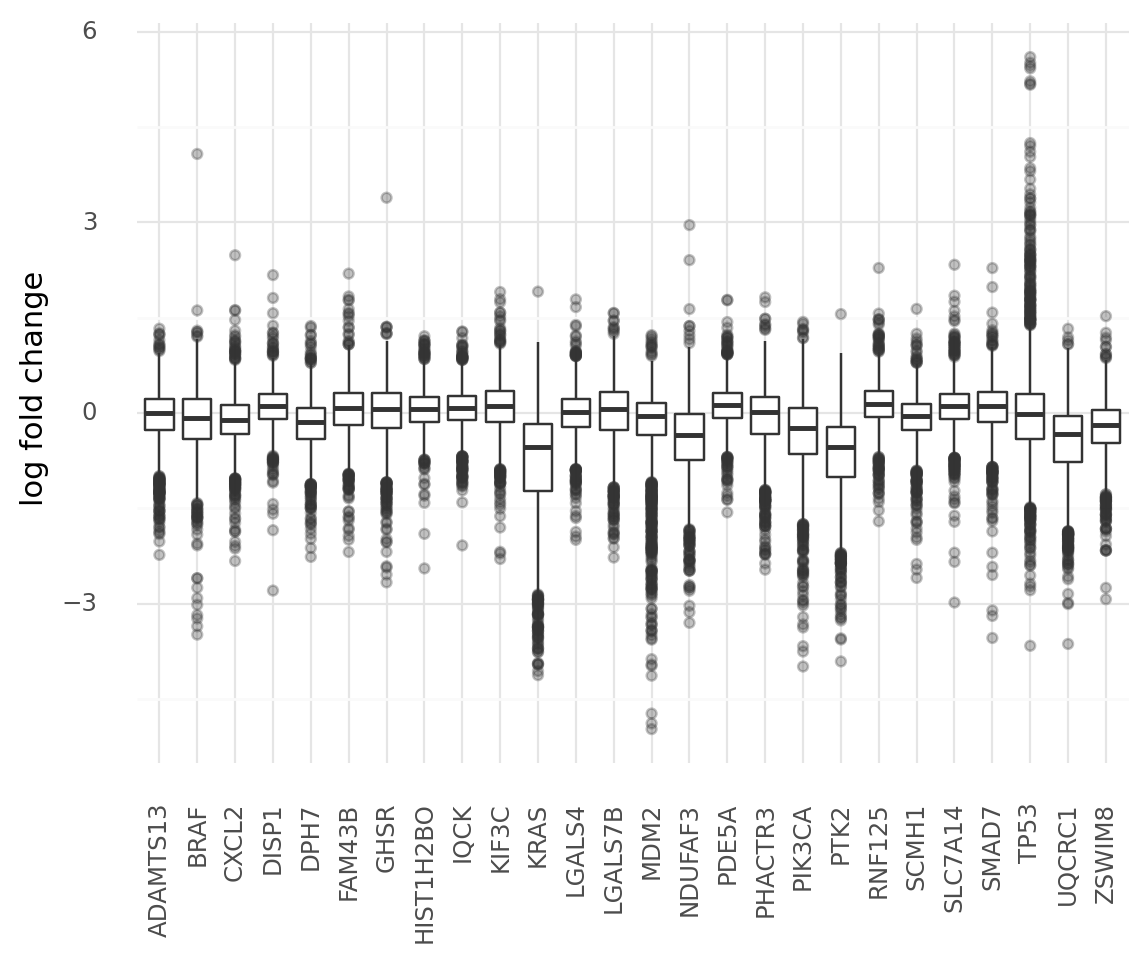

<ggplot: (8730623702851)>

In [8]:
(
    gg.ggplot(data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(outlier_alpha=0.3)
    + gg.theme(axis_text_x=gg.element_text(angle=90, hjust=0.5, vjust=1))
    + gg.labs(x=None, y="log fold change")
)

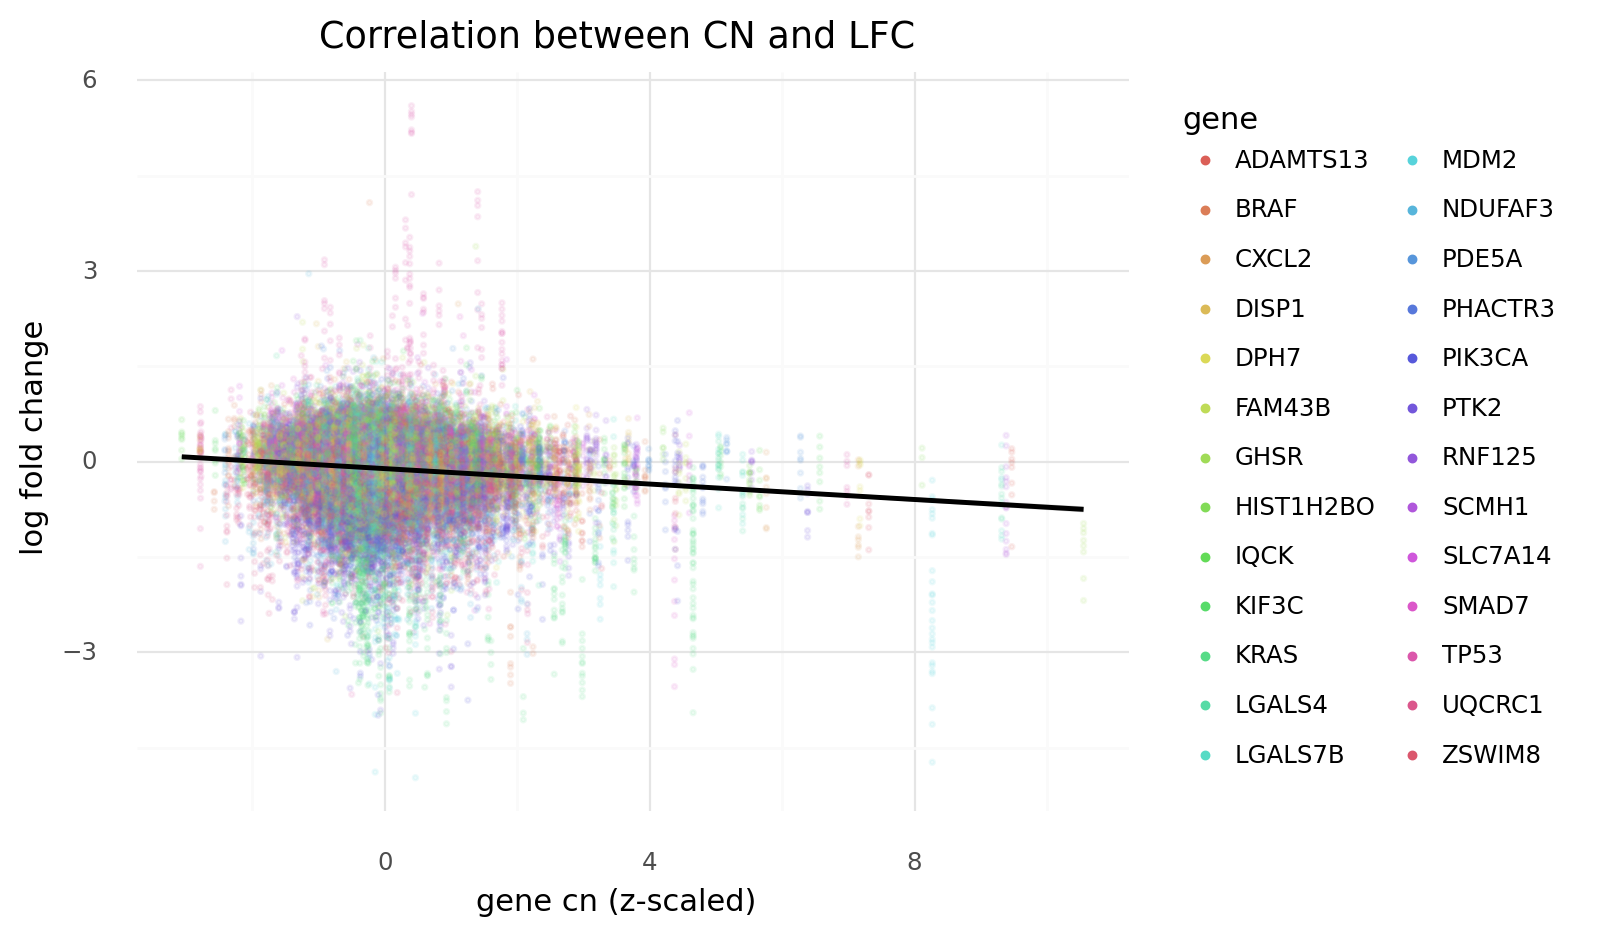

<ggplot: (8730613971318)>

In [9]:
p = (
    gg.ggplot(data, gg.aes(x="gene_cn_z", y="lfc"))
    + gg.geom_point(gg.aes(color="hugo_symbol"), alpha=0.1, size=0.5)
    + gg.geom_smooth()
    + gg.scale_color_discrete(
        guide=gg.guide_legend(override_aes={"size": 1, "alpha": 1})
    )
    + gg.labs(
        x="gene cn (z-scaled)",
        y="log fold change",
        title="Correlation between CN and LFC",
        color="gene",
    )
)
p

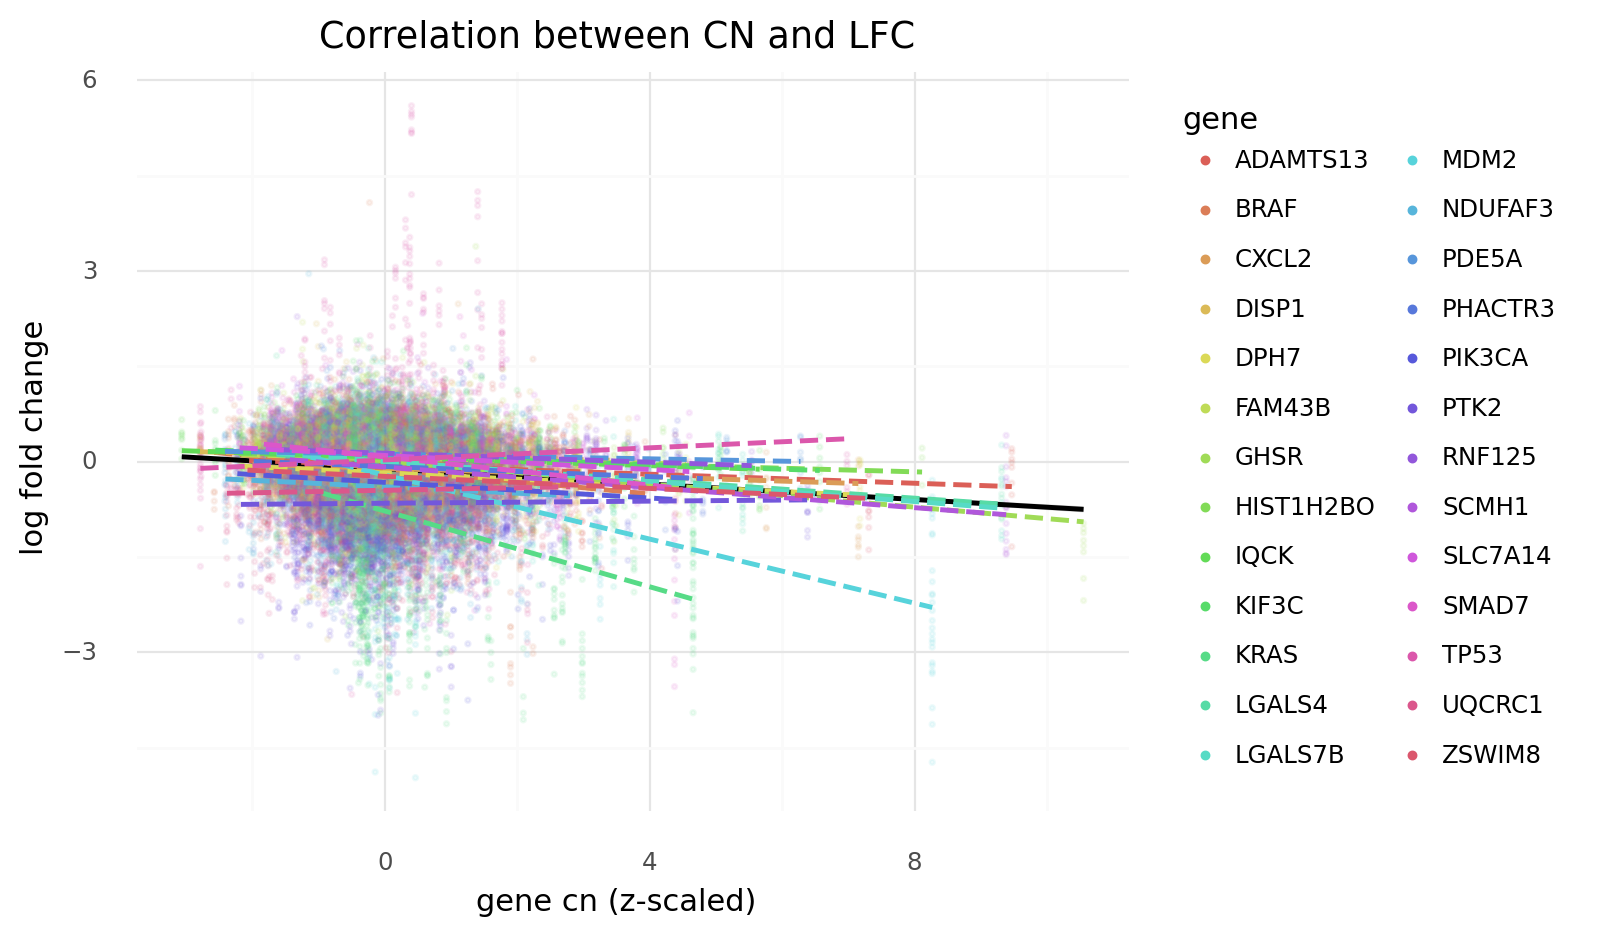

<ggplot: (8730613967008)>

In [10]:
(
    p
    + gg.geom_smooth(
        gg.aes(color="hugo_symbol"),
        linetype="--",
        alpha=0.5,
        se=False,
        show_legend=False,
    )
)

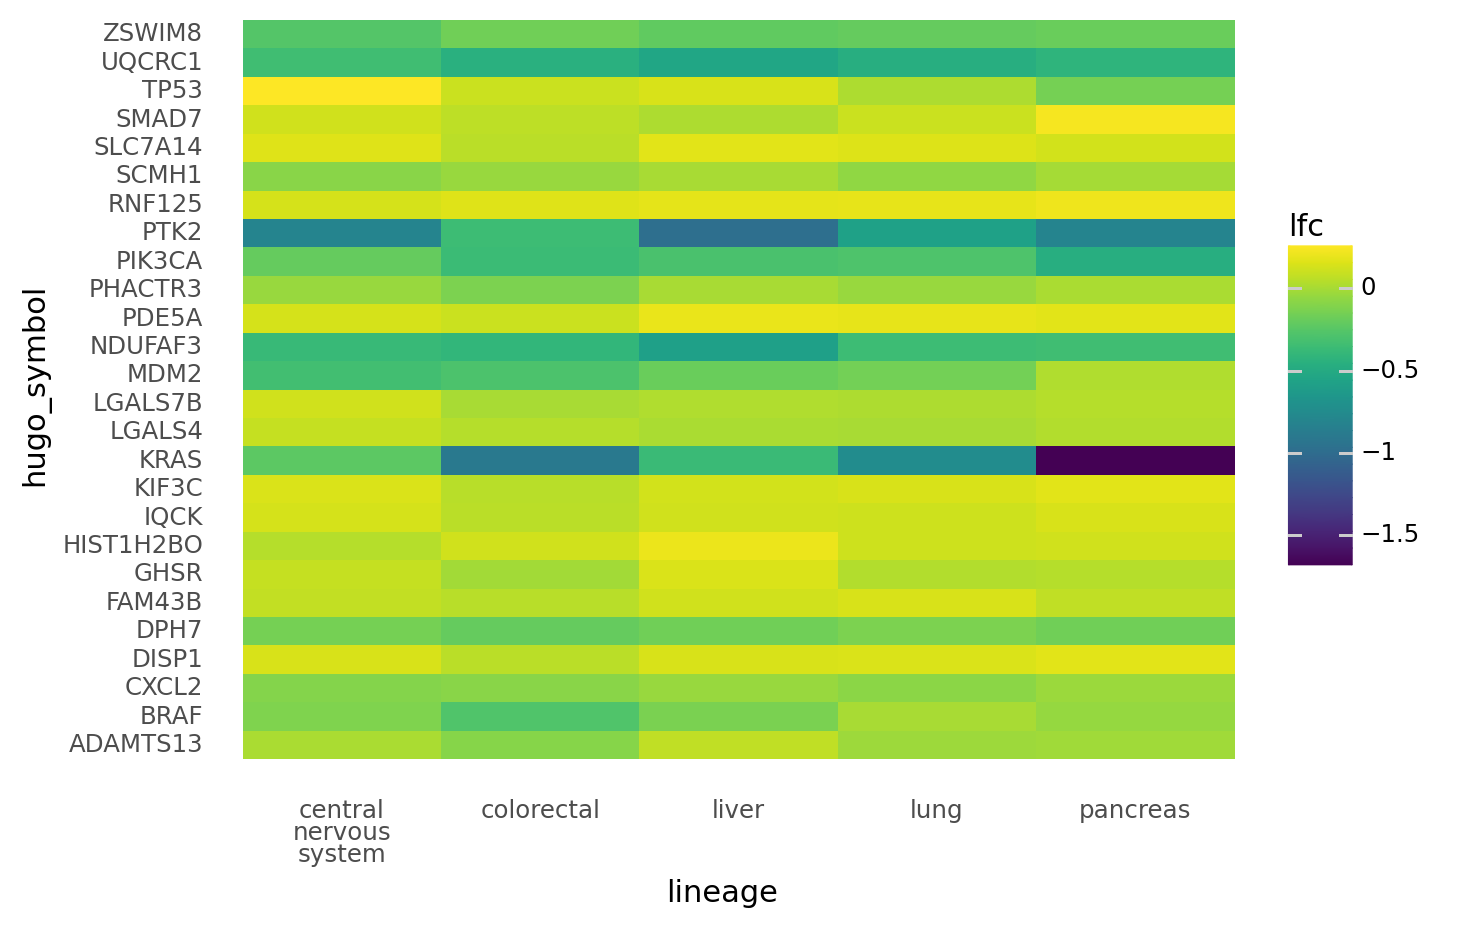

<ggplot: (8730612358867)>

In [11]:
d = data.groupby(["lineage", "hugo_symbol"]).mean().reset_index(drop=False)
d["lineage"] = stringr.str_replace(d["lineage"], "_", " ")
d["lineage"] = stringr.str_wrap(d["lineage"], width=10)

(
    gg.ggplot(d, gg.aes(x="lineage", y="hugo_symbol", fill="lfc"))
    + gg.geom_tile()
    + gg.scale_x_discrete(expand=(0, 0.5, 0, 0.5))
    + gg.scale_y_discrete(expand=(0, 0.5, 0, 0.5))
)

## Modeling

### Model 1. Hierarchical model by gene with no other variables

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_{g} \\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 5) \\
\sigma_\alpha \sim \text{HalfNormal}(0, 5) \\
\sigma \sim \text{HalfNormal}(0, 5)
$

In [12]:
gene_idx = get_indices(data, "hugo_symbol")
num_genes = data["hugo_symbol"].nunique()
with pm.Model() as m1:
    σ_α = pm.HalfNormal("σ_α", 5.0)
    μ_α = pm.Normal("μ_α", 0, 5)

    α_g = pm.Normal("α_g", μ_α, σ_α, shape=num_genes)
    μ = pm.Deterministic("μ", α_g[gene_idx])
    σ = pm.HalfNormal("σ", 5.0)

    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.lfc)

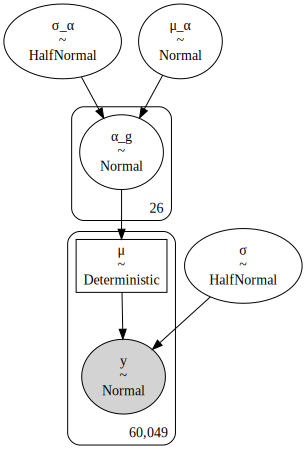

In [13]:
pm.model_to_graphviz(m1)

In [14]:
m1_cache_dir = pymc3_cache_dir / "subset_speclet_m1"

m1_sampling_results = pymc3_sampling_procedure(
    model=m1,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m1_cache_dir,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000},
)

Loading cached trace and posterior sample...


In [15]:
m1_az = samples_to_arviz(model=m1, res=m1_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


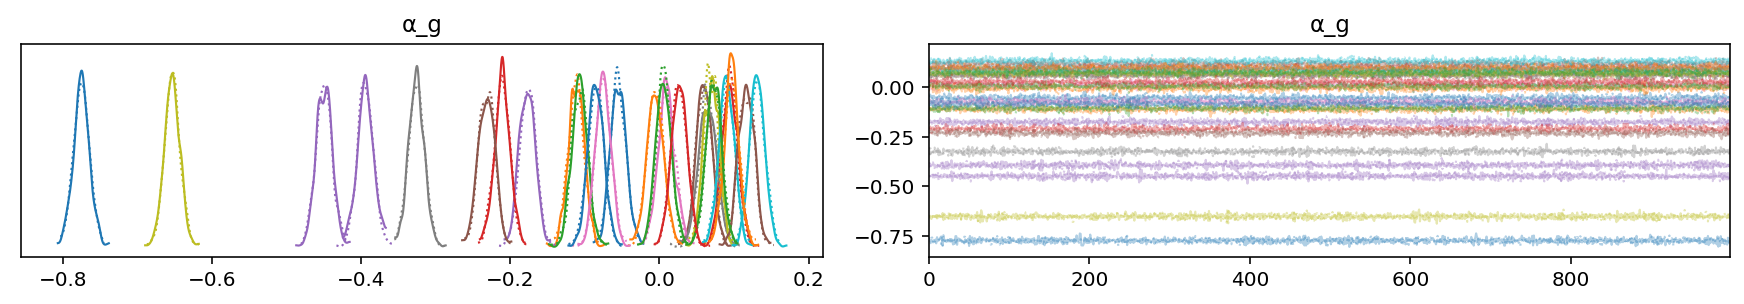

In [16]:
az.plot_trace(m1_az, var_names="α_g", compact=True)
plt.show()

### Model 2. Hierarchical model with a varying intercept per gene and a varying intercept per cell line

$
y \sim \mathcal{N}(\mu, \sigma) \\
\mu = \alpha_{g} + \beta_{l}\\
\alpha_g \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\mu_\alpha \sim \mathcal{N}(0, 2) \quad \sigma_\alpha \sim \text{HalfNormal}(0, 5) \\
\beta_c \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\mu_\beta \sim \mathcal{N}(0, 2) \quad \sigma_\beta \sim \text{HalfNormal}(0, 5) \\
\sigma \sim \text{HalfNormal}(0, 5)
$

In [17]:
gene_idx = get_indices(data, "hugo_symbol")
cellline_idx = get_indices(data, "depmap_id")
num_genes = data["hugo_symbol"].nunique()
num_celllines = data["depmap_id"].nunique()

with pm.Model() as m2:
    μ_α = pm.Normal("μ_α", -0.5, 1.0)
    σ_α = pm.HalfNormal("σ_α", 2.0)
    μ_β = pm.Normal("μ_β", 0, 1.0)
    σ_β = pm.HalfNormal("σ_β", 2.0)

    α_g = pm.Normal("α_g", μ_α, σ_α, shape=num_genes)
    β_c = pm.Normal("β_c", μ_β, σ_β, shape=num_celllines)
    μ = pm.Deterministic("μ", α_g[gene_idx] + β_c[cellline_idx])
    σ = pm.HalfNormal("σ", 2.0)

    y = pm.Normal("y", mu=μ, sigma=σ, observed=data.lfc)

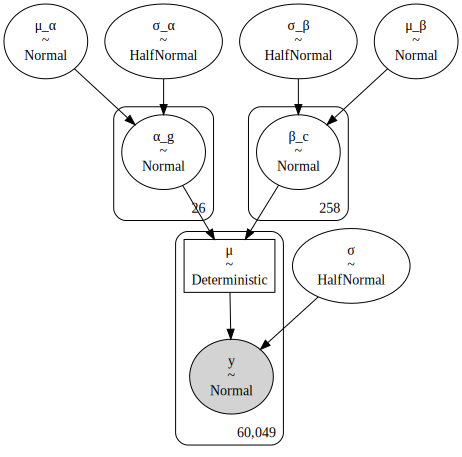

In [18]:
pm.model_to_graphviz(m2)

In [19]:
m2_cache_dir = pymc3_cache_dir / "subset_speclet_m2"

m2_sampling_results = pymc3_sampling_procedure(
    model=m2,
    num_mcmc=1000,
    tune=1000,
    chains=2,
    cores=2,
    random_seed=RANDOM_SEED,
    cache_dir=pymc3_cache_dir / m2_cache_dir,
    force=True,
    sample_kwargs={"init": "advi+adapt_diag", "n_init": 40000},
)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 28500
Interrupted at 28,499 [71%]: Average Loss = 56,428
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β_c, α_g, σ_β, μ_β, σ_α, μ_α]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 72 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Caching trace and posterior sample...


In [20]:
m2_az = samples_to_arviz(model=m2, res=m2_sampling_results)

arviz.data.io_pymc3 - WARNING - posterior predictive variable y's shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


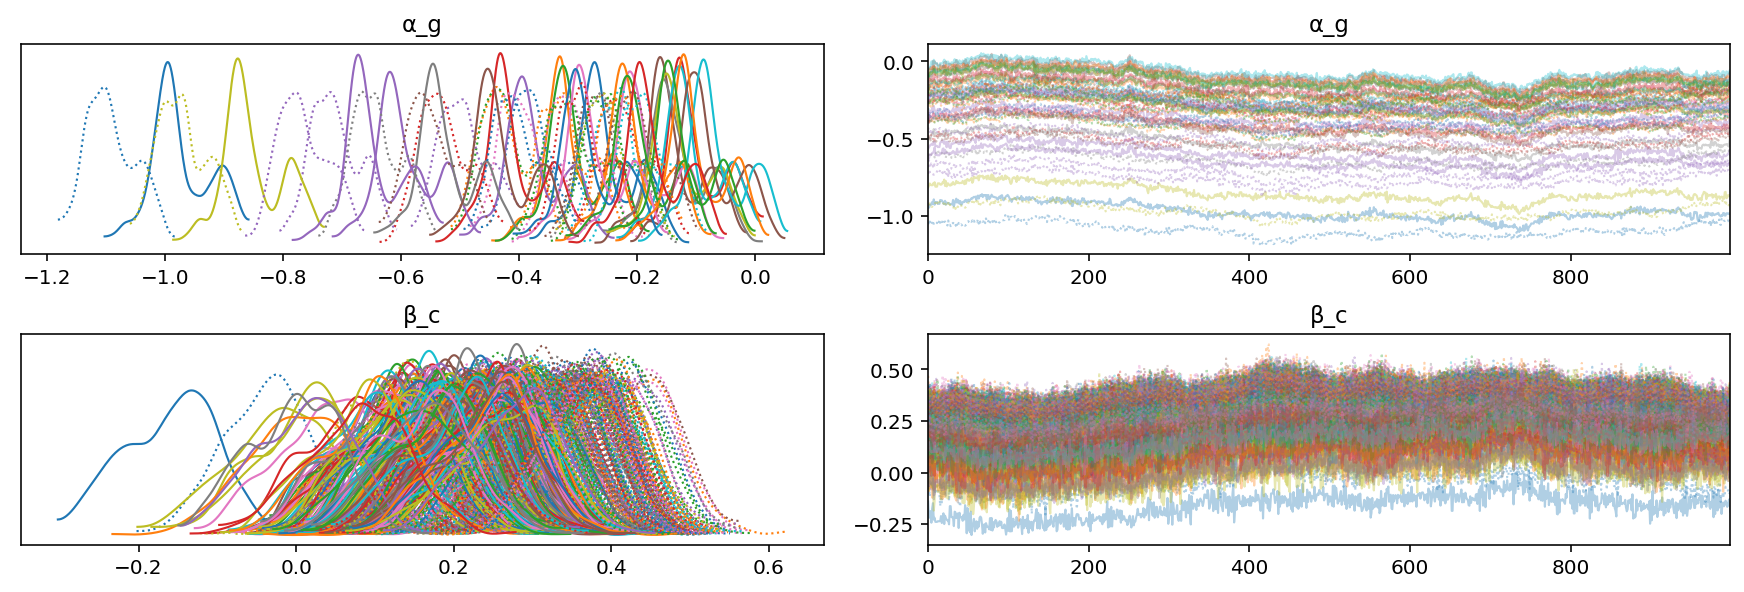

In [21]:
az.plot_trace(m2_az, var_names=["α_g", "β_c"], compact=True)
plt.show()

---

In [22]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 4.11 minutes


In [23]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-01-13

Python implementation: CPython
Python version       : 3.8.6
IPython version      : 7.19.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-171.o2.rc.hms.harvard.edu

Git branch: subset-data

re        : 2.2.1
matplotlib: 3.3.3
pymc3     : 3.9.3
plotnine  : 0.7.1
pandas    : 1.2.0
seaborn   : 0.11.1
theano    : 1.0.5
arviz     : 0.10.0
numpy     : 1.19.5

